# Energy Materials: Design, Discovery and Data

## 2. Solar Energy Conversion

## Advance Reading

Watch [Tutorial on Solar Cell Operation (MIT)](https://www.youtube.com/watch?v=qIJx2PRGKqw")

In [1]:
%%HTML 
<iframe width="560" height="315" src="https://www.youtube.com/embed/qIJx2PRGKqw" frameborder="0" allowfullscreen></iframe>

## Essentials

1. [NREL photovoltaic efficiency graph](http://www.nrel.gov/ncpv)
![](http://www.nrel.gov/pv/assets/images/efficiency_chart.jpg)
> Pro tip: this gets overused in conference presentations!

2. [Solar cell efficiency tables (version 49)](http://onlinelibrary.wiley.com/doi/10.1002/pip.2855/abstract)

## Lecture Slides 
On [Speakerdeck](https://speakerdeck.com/aronwalsh)

In [2]:
%%HTML 
<script async class="speakerdeck-embed" data-id="49e6ec3b817448c6a2ce1c23b78fef73" data-ratio="1.33333333333333" src="//speakerdeck.com/assets/embed.js"></script>

## pyExample: Shockley-Queisser Limit

Example adapted from http://sjbyrnes.com/sq.html using the standard [AM1.5 solar spectrum](http://rredc.nrel.gov/solar/spectra/am1.5/) and inspired by the [1961 publication](http://scitation.aip.org/content/aip/journal/jap/32/3/10.1063/1.1736034). 
The purpose is to see what what can be done with Python and the processes underpinning the Shockley-Queisser limit.

### Python Setup

In [3]:
import sys
assert sys.version_info >= (3,4)
import numpy, scipy.interpolate, scipy.integrate, urllib.request, io, tarfile
import numericalunits as nu
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Download and Process AM1.5 Solar Spectrum

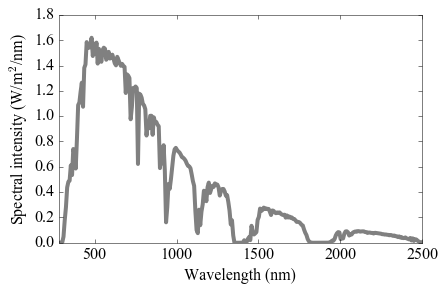

In [5]:
# Download data from NREL
Tcell = 300 * nu.K
data_url = 'http://rredc.nrel.gov/solar/spectra/am1.5/ASTMG173/compressed/ASTMG173.csv.tar'
download_as_bytes = urllib.request.urlopen(data_url).read()
download_as_file = io.BytesIO(download_as_bytes)
download_as_tarfile_object = tarfile.open(fileobj=download_as_file)
my_csv_file = download_as_tarfile_object.extractfile('ASTMG173.csv')
downloaded_array = numpy.genfromtxt(my_csv_file, delimiter=",", skip_header=2)

# Wavelength column 0, AM1.5G column 2
AM15 = downloaded_array[:,[0,2]]       

# AM1.5 units
AM15[:,0] *= nu.nm
AM15[:,1] *= nu.W * nu.m**-2 * nu.nm**-1
wavelength_min = 280 * nu.nm
wavelength_max = 4000 * nu.nm
E_min = nu.hPlanck * nu.c0 / wavelength_max
E_max = nu.hPlanck * nu.c0 / wavelength_min
AM15interp = scipy.interpolate.interp1d(AM15[:,0], AM15[:,1])

# Plot setup
plt.figure(figsize=(6,4))
fontSize = 16
mpl.rc('font', **{ 'family' : 'serif', 'size' : fontSize, 'serif' : 'Times New Roman' })
mpl.rc('lines', **{ 'linewidth' : 0.5 })
axes = plt.gca()
for spine in axes.spines.values():
    spine.set_linewidth(0.5)
plt.tight_layout()

# Plot AM1.5
wavelengths = numpy.linspace(wavelength_min, wavelength_max, num=500)
y_values = numpy.array([AM15interp(x) for x in wavelengths])
plot(wavelengths / nu.nm , y_values / (nu.W / nu.m**2 / nu.nm), linewidth = 4.0, color="gray")
xlabel("Wavelength (nm)")
xlim(280,2500)
ylabel("Spectral intensity (W/m$^2$/nm)");

### Integrate Solar Spectrum

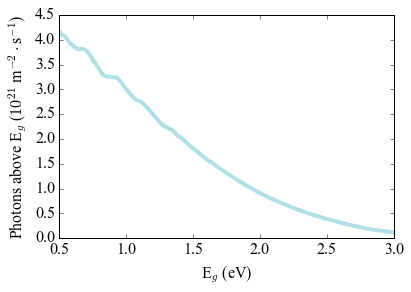

In [9]:
#Photons above bandgap
def SPhotonsPerTEA(Ephoton):
    wavelength = nu.hPlanck * nu.c0 / Ephoton
    return AM15interp(wavelength) * (1 / Ephoton) * (nu.hPlanck * nu.c0 / Ephoton**2)
def solar_photons_above_gap(Egap):
    return scipy.integrate.quad(SPhotonsPerTEA, Egap, E_max, full_output=1)[0]
PowerPerTEA = lambda E : E * SPhotonsPerTEA(E)
solar_constant = scipy.integrate.quad(PowerPerTEA,E_min,E_max, full_output=1)[0]
Egap_list = numpy.linspace(0.5 * nu.eV, 3.0 * nu.eV, num=100)
y_values = numpy.array([solar_photons_above_gap(E) for E in Egap_list])

# Plot data
plot(Egap_list / nu.eV , y_values / (1e21 * nu.m**-2 * nu.s**-1), linewidth = 4.0, color="powderblue")
xlabel("E$_g$ (eV)")
xlim(0.5,3.0)
ylabel("Photons above E$_g$ ($10^{21}$ m$^{-2} \cdot $s$^{-1}$)");

### Voltage and Current Limits

In [10]:
# Current and voltage
bandgap = 1.6

# Include radiative recombination (RR0)
def RR0(Egap):
    integrand = lambda E : E**2 / (exp(E / (nu.kB * Tcell)) - 1)
    integral = scipy.integrate.quad(integrand, Egap, E_max, full_output=1)[0]
    return ((2 * pi) / (nu.c0**2 * nu.hPlanck**3)) * integral
def current_density(V, Egap):
    return nu.e * (solar_photons_above_gap(Egap) - RR0(Egap) * exp(nu.e * V / (nu.kB * Tcell)))
def JSC(Egap):
    return current_density(0, Egap)
def VOC(Egap):
    return (nu.kB * Tcell / nu.e) * log(solar_photons_above_gap(Egap) / RR0(Egap))
print ("Eg = ", bandgap, "eV")
print("Max short-circuit current = ", JSC(bandgap * nu.eV) / (nu.mA / nu.cm**2), "mA/cm2")
print("Max open-circuit voltage = ", VOC(bandgap * nu.eV) / nu.V, "V")

Eg =  1.6 eV
Max short-circuit current =  25.473387278 mA/cm2
Max open-circuit voltage =  1.32449437925 V


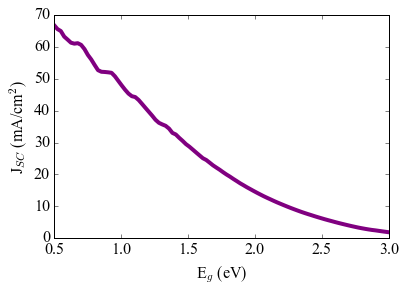

In [54]:
# Short circuit current
Egap_list = numpy.linspace(0.5 * nu.eV, 3 * nu.eV, num=100)
JSC_list = numpy.array([JSC(E) for E in Egap_list])
plot(Egap_list / nu.eV , JSC_list / (nu.mA / nu.cm**2), linewidth = 4.0, color="purple")
xlabel("E$_g$ (eV)")
ylabel("J$_{SC}$ (mA/cm$^2$)")
xlim(0.5,3.0)
ylim(0,70);

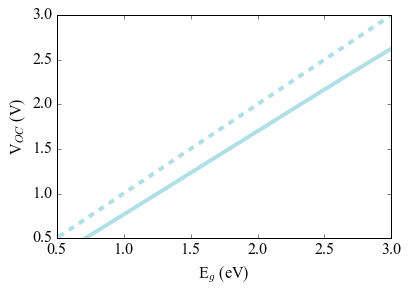

In [55]:
# Open circuit voltage
Egap_list = numpy.linspace(0.5 * nu.eV, 3 * nu.eV, num=20)
VOC_list = numpy.array([VOC(E) for E in Egap_list])
plot(Egap_list / nu.eV , VOC_list / nu.V,
     numpy.linspace(0,3) , numpy.linspace(0,3), '--', linewidth = 4.0, color="powderblue")
xlabel("E$_g$ (eV)")
ylabel("V$_{OC}$ (V)")
ylim(0.5,3.0)
xlim(0.5,3.0);

### S-Q Single-Junction Efficiency Limit

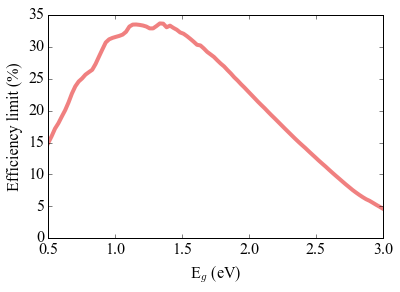

In [56]:
# Warning: this part is slow to run!
from scipy.optimize import fmin
def fmax(func_to_maximize, initial_guess=0):
    """return the x that maximizes func_to_maximize(x)"""
    func_to_minimize = lambda x : -func_to_maximize(x)
    return fmin(func_to_minimize, initial_guess, disp=False)[0]
def V_mpp(Egap):
    """ voltage at max power point """
    return fmax(lambda V : V * current_density(V, Egap))
def J_mpp(Egap):
    """ current at max power point """
    return current_density(V_mpp(Egap), Egap)
def max_power(Egap):
    V = V_mpp(Egap)
    return V * current_density(V, Egap)
def max_efficiency(Egap):
    return max_power(Egap) / solar_constant

Egap_list = numpy.linspace(0.5 * nu.eV, 3 * nu.eV, num=100)
eff_list = numpy.array([max_efficiency(E) for E in Egap_list])
plot(Egap_list / nu.eV , 100 * eff_list,  linewidth = 4.0, color="lightcoral")
xlabel("E$_g$ (eV)")
ylabel("Efficiency limit (%)")
xlim(0.5,3)
ylim(0,35);

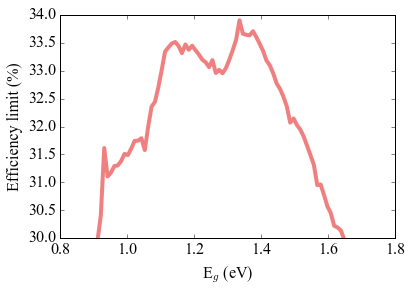

In [57]:
# Peak analysis
#Egap_list = numpy.linspace(0.8 * nu.eV, 1.8 * nu.eV, num=100)
#eff_list = numpy.array([max_efficiency(E) for E in Egap_list])
plot(Egap_list / nu.eV , 100 * eff_list,  linewidth = 4.0, color="lightcoral")
xlabel("E$_g$ (eV)")
ylabel("Efficiency limit (%)")
xlim(0.8,1.8)
ylim(30,34);

### Breakdown of Loss Mechanisms

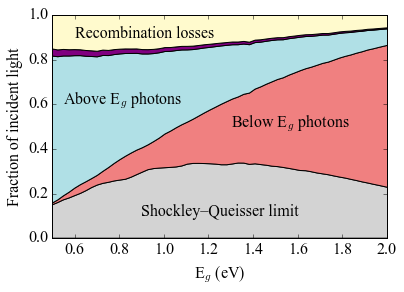

In [58]:
# Loss mechanism breakdown
# Warning: this part is slow to run!
def useful_electricity(Egap):
    return max_efficiency(Egap)
def below_gap_energy(Egap):
    integrand = lambda E : E * SPhotonsPerTEA(E)
    return scipy.integrate.quad(integrand, E_min, Egap, full_output=1)[0] / solar_constant
def excess_beyond_gap(Egap):
    integrand = lambda E : (E - Egap) * SPhotonsPerTEA(E)
    return scipy.integrate.quad(integrand, Egap, E_max, full_output=1)[0] / solar_constant
def mpp_recombination(Egap):
    return (solar_photons_above_gap(Egap) - J_mpp(Egap) / nu.e) * Egap / solar_constant
def mpp_voltage_is_less_than_gap(Egap):
    return J_mpp(Egap) * (Egap / nu.e - V_mpp(Egap)) / solar_constant
#
Egap_list = linspace(0.5 * nu.eV, 3 * nu.eV, num=100)
loss_list = [[useful_electricity(Egap), below_gap_energy(Egap), excess_beyond_gap(Egap),
                      mpp_recombination(Egap), mpp_voltage_is_less_than_gap(Egap)] for Egap in Egap_list]
loss_list = array(loss_list)
# Cumulative sums to stack the contributions 
loss_list = cumsum(loss_list,axis=1)

# Final plot
fig = figure()
ax1 = fig.add_subplot(111)
# Useful power
ax1.fill_between(Egap_list / nu.eV,              0, loss_list[:,0], facecolor="lightgray")
# Below gap photons
ax1.fill_between(Egap_list / nu.eV, loss_list[:,0], loss_list[:,1], facecolor="lightcoral")
# Above gap relaxation
ax1.fill_between(Egap_list / nu.eV, loss_list[:,1], loss_list[:,2], facecolor="powderblue")
# Current loss - recombination
ax1.fill_between(Egap_list / nu.eV, loss_list[:,2], loss_list[:,3], facecolor="purple")
# Voltage loss - recombination
ax1.fill_between(Egap_list / nu.eV, loss_list[:,3],              1, facecolor="lemonchiffon")
#
ax1.annotate('Recombination losses', xy=(0.6, 0.9), xytext=(0.6, 0.9))
ax1.annotate('Shockley–Queisser limit', xy=(0.9, 0.1), xytext=(0.9, 0.1))
ax1.annotate('Below E$_g$ photons', xy=(1.3, 0.5), xytext=(1.3, 0.5))
ax1.annotate('Above E$_g$ photons', xy=(0.55, 0.6), xytext=(0.55, 0.6))
#
xlabel("E$_g$ (eV)")
ylabel('Fraction of incident light')
xlim(0.5,2.0)
ylim(0,1);

## Supplementary Links 

### Review Papers

* [Photovoltaic materials: Present efficiencies and future challenges](http://science.sciencemag.org/content/352/6283/aad4424) (Science, 2016)

* [Energy conversion approaches and materials for high-efficiency photovoltaics](http://www.nature.com/nmat/journal/v16/n1/full/nmat4676.html) (Nature Materials, 2017)

### General Background

* http://www.pveducation.org/pvcdrom 

* [Physics of solar cells](https://books.google.co.uk/books/about/The_Physics_of_Solar_Cells.html?id=s5NN34HLWO8C&redir_esc=y) (Textbook by Jenny Nelson)